# WMT of surface terms and $\frac{dM}{dt}$

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
#import regionate as reg

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filepath=None):
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/{filepath}surf_ds.zarr'))
    return ds

In [3]:
#add the last 3 months to each ds
ds2018 = xr.concat([open_ds('2018_'), open_ds('2018_winter_')], dim='time')
ds2019 = xr.concat([open_ds('2019_'), open_ds('2019_winter_')], dim='time')
ds2020 = xr.concat([open_ds('2020_'), open_ds('2020_winter_')], dim='time')
ds2021 = xr.concat([open_ds('2021_'), open_ds('2021_winter_')], dim='time')
ds2022 = xr.concat([open_ds('2022_'), open_ds('2022_winter_')], dim='time')
ds2023 = open_ds('')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

In [4]:
sst_c = xr.concat([ds2023.sst.isel(expver=0).sel(time=slice(None, '2023-06')),
                   ds2023.sst.isel(expver=1).sel(time=slice('2023-07', None))], dim='time')
runoff_c = xr.concat([ds2023.ro.isel(expver=0).sel(time=slice(None, '2023-07-27')),
                   ds2023.ro.isel(expver=1).sel(time=slice('2023-07-28', None))], dim='time')
rest_c = xr.concat([ds2023.drop(['ro', 'sst']).isel(expver=0).sel(time=slice(None, '2023-08-01')),
                   ds2023.drop(['ro', 'sst']).isel(expver=1).sel(time=slice('2023-08-02', None))], dim='time')

In [5]:
ds2023_c = xr.merge([sst_c.drop('expver'), runoff_c.drop('expver'), rest_c.drop('expver')])

In [6]:
ds2023_c

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 6485)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-09-28T04:00:00
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [7]:
ds_unsorted = xr.concat([ds2018, ds2019, ds2020, ds2021, ds2022, ds2023_c], dim='time')
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = ds_unsorted.sortby(ds_unsorted.latitude)

In [8]:
ds

<xarray.Dataset>
Dimensions:    (time: 50309, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
Data variables:
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-08 19:47:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## values' last day before change from expver=0 to expver=1
- `2023-06-30`: `sst`
- `2023-07-27`: `ro`
- `2023-08-01`: `evap` `slhf` `sro` `sshf` `ssr` `ssrd` `ssro` `str` `strd`

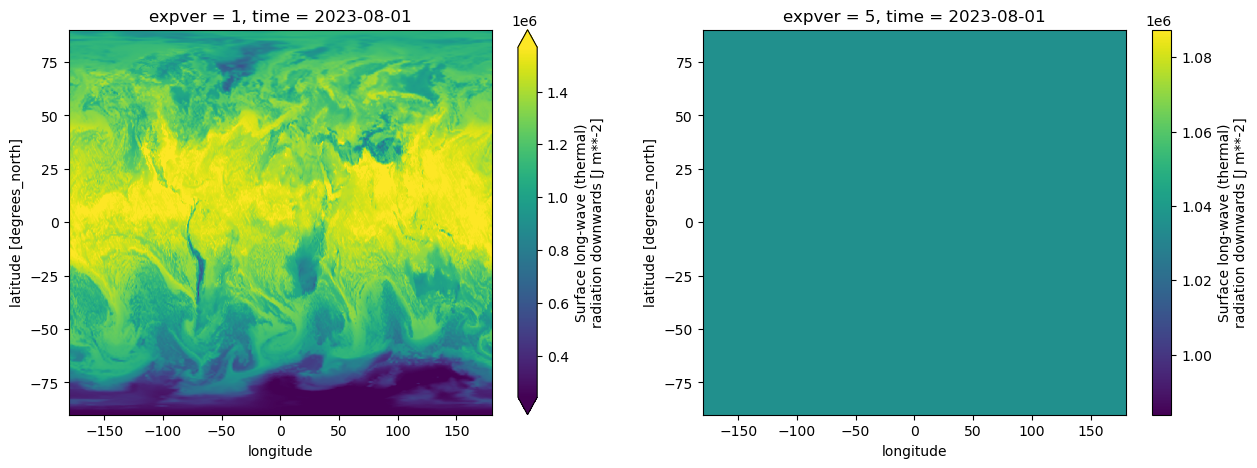

In [155]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ds2023.strd.sel(time='2023-08-01', method='nearest').isel(expver=0).plot(ax=ax0, robust=True)
ds2023.strd.sel(time='2023-08-01', method='nearest').isel(expver=1).plot(ax=ax1, robust=True)

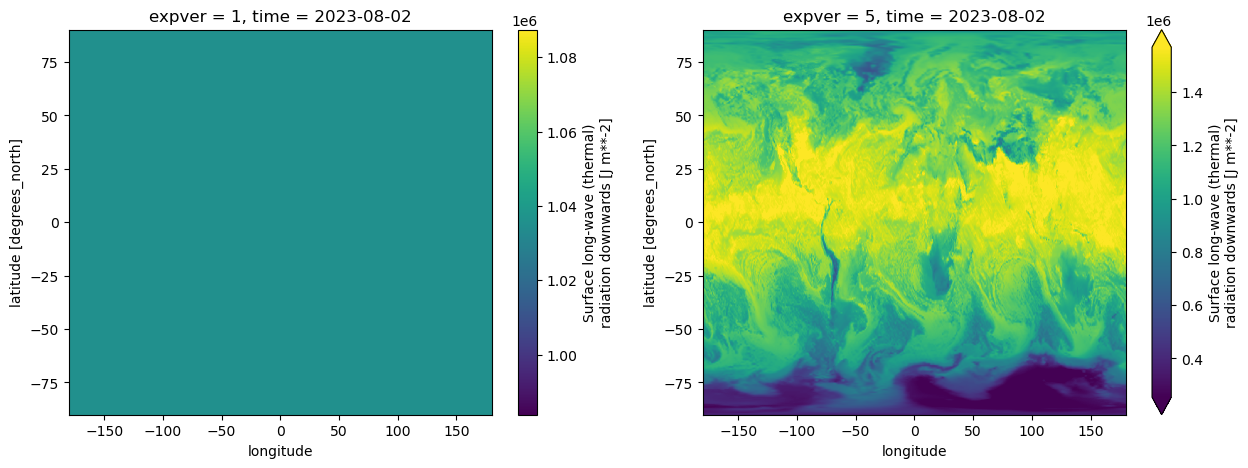

In [156]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ds2023.strd.sel(time='2023-08-02', method='nearest').isel(expver=0).plot(ax=ax0, robust=True)
ds2023.strd.sel(time='2023-08-02', method='nearest').isel(expver=1).plot(ax=ax1, robust=True)

## Create grid and area objects

In [9]:
ds_full = generate_grid_ds(ds, {'X':'longitude', 'Y':'latitude'})

In [10]:
ds_full

<xarray.Dataset>
Dimensions:         (time: 50309, latitude: 721, longitude: 1440,
                     longitude_left: 1440, latitude_left: 721)
Coordinates:
  * latitude        (latitude) float32 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude       (longitude) float32 -180.0 -179.8 -179.5 ... 179.5 179.8
  * time            (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
  * longitude_left  (longitude_left) float32 -180.1 -179.9 ... 179.4 179.6
  * latitude_left   (latitude_left) float32 -90.12 -89.88 -89.62 ... 89.62 89.88
Data variables:
    e               (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro              (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro             (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr             (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst             (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str             (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-08 19:47:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [11]:
ds_full.latitude_left

<xarray.DataArray 'latitude_left' (latitude_left: 721)>
array([-90.125, -89.875, -89.625, ...,  89.375,  89.625,  89.875],
      dtype=float32)
Coordinates:
  * latitude_left  (latitude_left) float32 -90.12 -89.88 -89.62 ... 89.62 89.88
Attributes:
    axis:               Y
    c_grid_axis_shift:  -0.5

In [12]:
grid = xgcm.Grid(ds_full, periodic=['X'])

In [13]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
Y Axis (not periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center

In [14]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [15]:
#converting lat from degrees to meters
delta_lat = grid.diff(ds_full.latitude, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree
delta_lat_l = grid.diff(ds_full.latitude_left, 'Y', boundary='fill', fill_value=np.nan)
dy_l = delta_lat_l * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid.diff(ds_full.longitude, 'X')#, boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_full.latitude))
delta_lon_l = grid.diff(ds_full.longitude_left, 'X')#, boundary_discontinuity=360)
dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_full.latitude_left))

In [16]:
cell_elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])

In [17]:
cell_elements

<xarray.Dataset>
Dimensions:         (longitude_left: 1440, latitude: 721, longitude: 1440,
                     latitude_left: 721)
Coordinates:
  * longitude_left  (longitude_left) float32 -180.1 -179.9 ... 179.4 179.6
  * latitude        (latitude) float32 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude       (longitude) float32 -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude_left   (latitude_left) float32 -90.12 -89.88 -89.62 ... 89.62 89.88
Data variables:
    dx              (longitude_left, latitude) float32 1.749 ... -0.001215
    dx_l            (longitude, latitude_left) float32 -60.65 ... -8.727e+04
    dy              (latitude_left) float32 nan 2.78e+04 ... 2.78e+04 2.78e+04
    dy_l            (latitude) float32 2.78e+04 2.78e+04 ... 2.78e+04 nan

In [18]:
gulf = dict(longitude=slice(-100, -72), latitude=slice(22, 31),
            longitude_left=slice(-100, -72), latitude_left=slice(22, 31))

In [19]:
ds_trop = ds_full.sel(**gulf)
cells_trop = cell_elements.sel(**gulf)

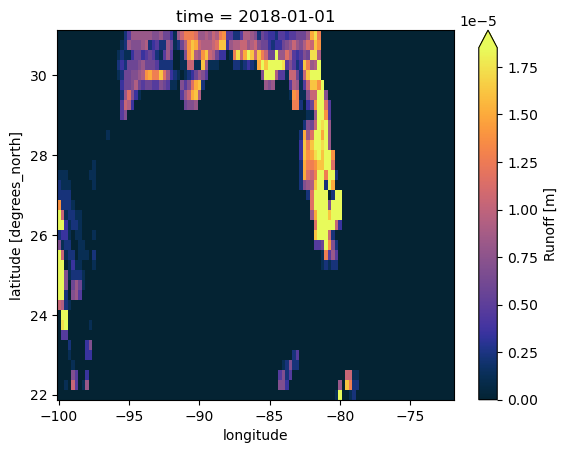

In [20]:
ds_trop.ro[0].plot(robust=True, cmap=cmocean.cm.thermal)

In [21]:
mask = ds_trop.sst[0].isnull()

/tmp/ipykernel_501/1634276531.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


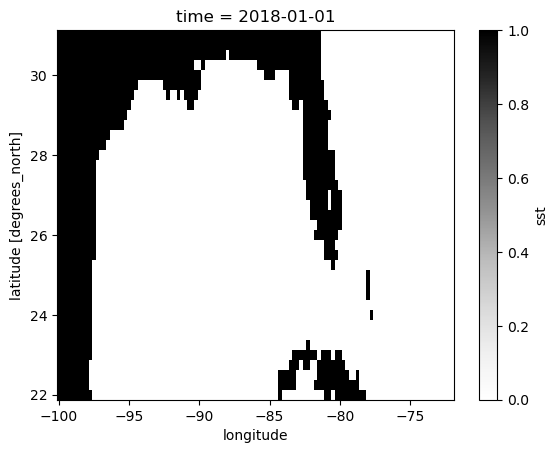

In [22]:
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap)

/tmp/ipykernel_501/3909106207.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


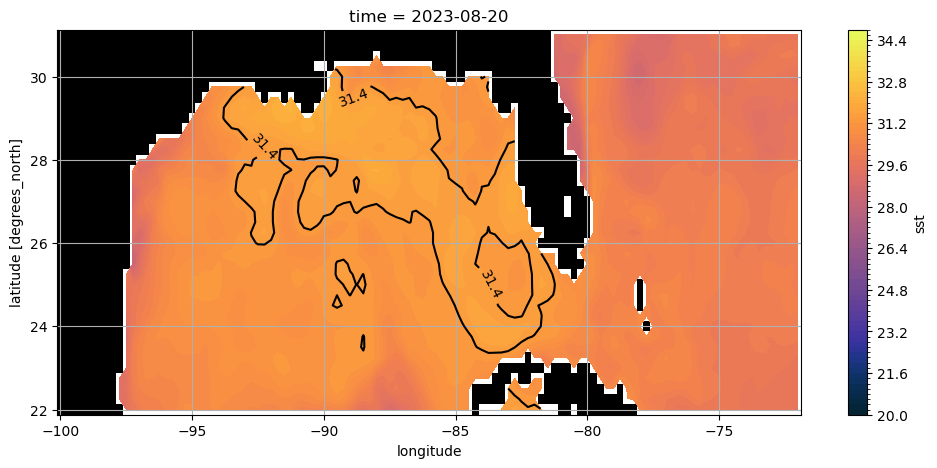

In [23]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap, add_colorbar=False)

(ds_trop.sst-273.15).sel(time='2023-08-20', method='nearest').plot.contourf(levels=np.arange(20, 35, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = (ds_trop.sst-273.15).sel(time='2023-08-20', method='nearest').plot.contour(levels=[31.4], colors='k')
plt.clabel(c)
plt.grid();

# Budget

In [24]:
ds_trop_new = ds_trop / 3600 #divide by total sec in an hour to get time dim

In [34]:
sw = ds_trop_new.ssr #J/m^2 s
lw = ds_trop_new.str #J/m^2 s
sensible = ds_trop_new.sshf #J/m^2 s
latent = ds_trop_new.slhf #J/m^2 s
evap = ds_trop_new.e #m/s
runoff = ds_trop_new.ro #m/s
#precip = #m/s

In [33]:
#short-longwave; sensible latent
slsl = xr.merge([sw, lw, sensible, latent])
#e-p-r 
epr = xr.merge([evap, runoff])#, precip])
#resample to daily
slsl_resampled = slsl.resample(time='D').mean()
epr_resampled = epr.resample(time='D').mean()

In [35]:
theta_resampled = (ds_trop.sst - 273.15).resample(time='D').mean()

In [27]:
slsl_resampled

<xarray.Dataset>
Dimensions:    (time: 2097, latitude: 37, longitude: 113)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28
Data variables:
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(1, 37, 113), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(1, 37, 113), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(1, 37, 113), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(1, 37, 113), meta=np.ndarray>

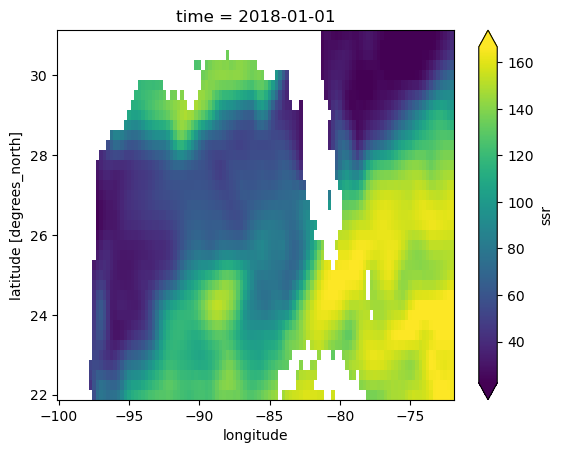

In [28]:
slsl_resampled.ssr[0].where(~mask).plot(robust=True)

In [29]:
grid_trop = xgcm.Grid(ds_trop, periodic=['X'])

In [30]:
dx_interp = grid_trop.interp(cells_trop.dx_l, 'Y')
area = dx_interp * cells_trop.dy_l

In [36]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1034 #kg/m^3
#alpha = 3e-4 #1/˚C from DOI:10.1126/sciadv.abq0793

#var (J/m^2 s) x 1/Cp x area x alpha
slsl_weighted = slsl_resampled * area * (1/Cp) #˚C kg/s

#var (m/s) x area x rho
epr_weighted = epr_resampled * area * rho * theta_resampled

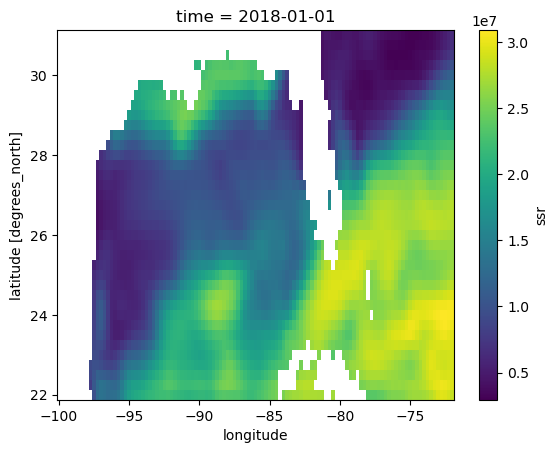

In [37]:
slsl_weighted.ssr[0].where(~mask).plot()

In [38]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 15  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [39]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.d0caa34d09b74ee5a5a727c487db30d5/status,


In [40]:
delta_theta = 0.1
theta_bins = np.arange(20,34,delta_theta)

def hist_func(ds, variable):
    hist = histogram(theta_resampled.where(~mask).rename('theta'), bins=[theta_bins],
                    weights=(ds[variable].where(~mask).fillna(0.)),
                    dim=['longitude', 'latitude']) / delta_theta
    return hist #kg/s

In [41]:
#rename vars with `omega_` as prefix to highlight new hist ds
slsl_hist = xr.merge([hist_func(slsl_weighted, var).rename('omega_' + var) for var in list(slsl_weighted)])
epr_hist =xr.merge([hist_func(epr_weighted, var).rename('omega_' + var) for var in list(epr_weighted)])

In [42]:
slsl_hist

<xarray.Dataset>
Dimensions:     (time: 2097, theta_bin: 139)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28
  * theta_bin   (theta_bin) float64 20.05 20.15 20.25 ... 33.65 33.75 33.85
Data variables:
    omega_ssr   (time, theta_bin) float32 dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_str   (time, theta_bin) float32 dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_sshf  (time, theta_bin) float32 dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_slhf  (time, theta_bin) float32 dask.array<chunksize=(1, 139), meta=np.ndarray>

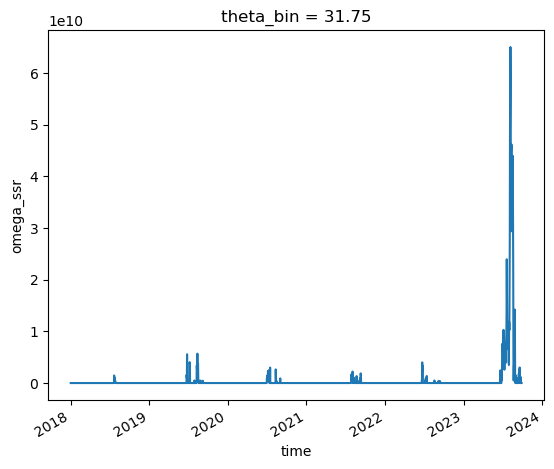

In [43]:
slsl_hist.omega_ssr.sel(theta_bin=31.8, method='nearest').plot()

- sw = ssr 
- lw = str 
- sensible = sshf 
- latent = slhf 
- evap = e 
- runoff = ro 

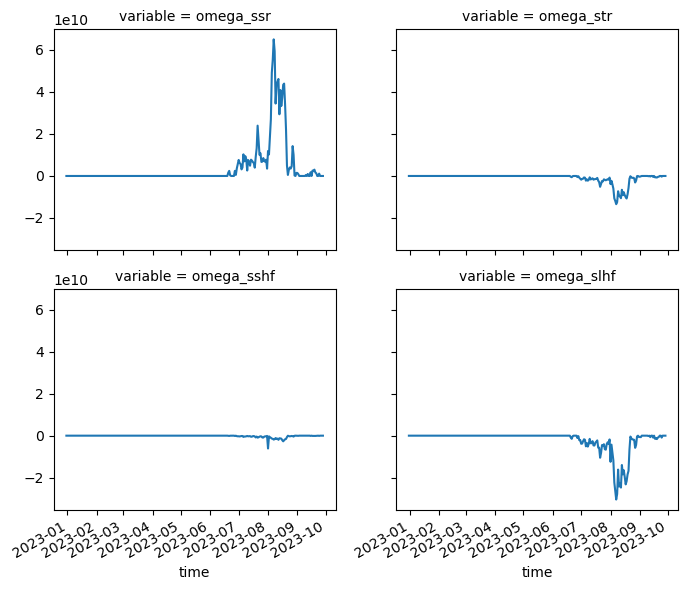

In [44]:
slsl_hist.sel(theta_bin=31.8, method='nearest').sel(time=slice('2022-12-31', 
                                                               None)).to_array().plot(col='variable', col_wrap=2)

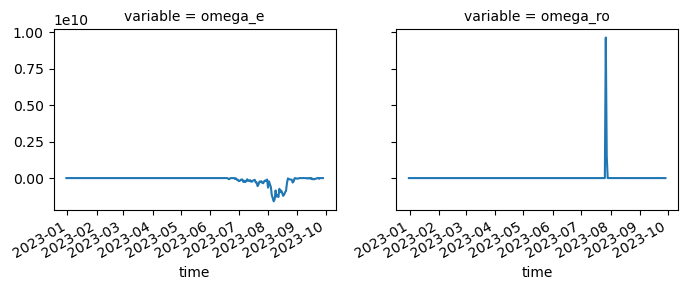

In [45]:
epr_hist.sel(theta_bin=31.8, method='nearest').sel(time=slice('2022-12-31', 
                                                               None)).to_array().plot(col='variable')

In [54]:
one_plt = slsl_hist.sel(theta_bin=31.8, method='nearest').sel(time=slice('2022-12-31', None))
epr_one_plt = epr_hist.sel(theta_bin=31.8, method='nearest').sel(time=slice('2022-12-31', None))

- sw = ssr 
- lw = str 
- sensible = sshf 
- latent = slhf 
- evap = e 
- runoff = ro 

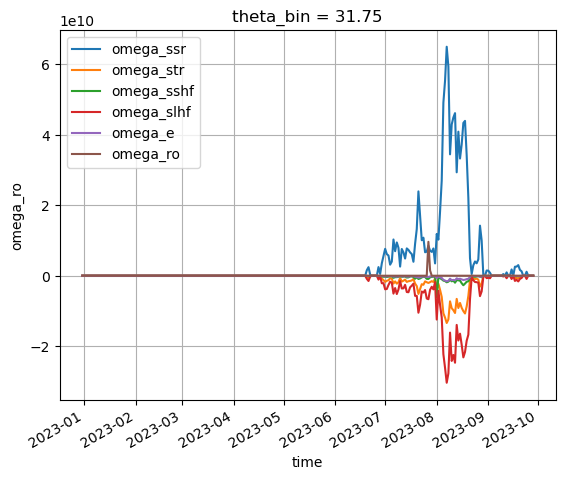

In [56]:
[one_plt[v].plot(label=v) for v in one_plt.data_vars]
[epr_one_plt[ev].plot(label=ev) for ev in epr_one_plt.data_vars]
plt.grid()
plt.legend()

In [57]:
client.close()
cluster.close()